# 1 Covid-19 Data Collection and Wrangling<a id='1_data_collection_wrangling'></a>

## 1.1 Contents<a id='1.1_contents'></a>
* [1 Covid-19 Data Collection and Wrangling](#1_data_collection_wrangling)
  * [1.1 Contents](#1.1_contents)  
  * [1.2 Imports](#1.2_imports)
  * [1.3 Functions](#1.3_functions)
      * [1.3.1 Function: add_vaccination](#1.3.1_add_vaccination)
      * [1.3.2 Function: add_case](#1.3.2_add_case)
      * [1.3.3 Function: add_weather](#1.3.3_add_weather)
      * [1.3.4 Function: country_name_to_iso2](#1.3.4_country_name_to_iso2)
      * [1.3.5 Function: add holiday](#1.3.5_add_holiday)
      * [1.3.6 Function: vac_iso_code_to_alpha2](#1.3.6_vac_iso_code_to_alpha2)
      * [1.3.7 Function: case_name_to_alpha2](#1.3.7_case_name_to_alpha2) 
  * [1.4 Load data](#1.4_load_data)
  * [1.5 Preprocess mobility data](#1.5_preprocess_mobility_data)
  * [1.6 Merge data](#1.6_merge_data)
  * [1.7 Save data](#1.7_save_data)
  * [1.8 Appendix](#1.8_appendix)

## 1.2 Imports<a id='1.2_imports'></a>

In [1]:
from collections import defaultdict
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from pathlib import Path
from deepdiff import DeepDiff
from pandas.tseries.holiday import USFederalHolidayCalendar as holidayCalendar
from wwo_hist import retrieve_hist_data
import pycountry
import holidays
from countryinfo import CountryInfo
%matplotlib inline

## 1.3 Functions<a id='1.3_functions'></a>

#### 1.3.1 Functions: add_vaccination <a id='1.3.1_add_vaccination'></a>

In [265]:
def add_vaccination(df_place, df_vac, country_code):
    # join the vaccination data
    df_place_vac = df_vac.loc[df_vac["iso_code"]==country_code,["date","people_vaccinated_per_hundred"]]
    df_place_vac.rename(columns = {"people_vaccinated_per_hundred": "vac"}, inplace=True)
    df_place_vac["date"] = pd.to_datetime(df_place_vac.date) # convert the index to datetime64
    df_place_vac.set_index("date", drop=True ,inplace=True)
    df_place = df_place.merge(df_place_vac, on="date", how="left")
    # fill in missing values for vaccination
    if np.isnan(df_place["vac"][0]): # if the initial value is NaN, put 0
        df_place.loc[df_place.index[0],"vac"]=0
    df_place.loc[:,"vac"] = df_place["vac"].fillna(method='ffill') # must assign the filled list to the "vac" column
    return df_place

#### 1.3.2 Functions: add_case <a id='1.3.2_add_case'></a>

In [264]:
def add_case(df_place, df_case, country_code):
    # join the case data
    df_place_case = df_case.loc[:,["date", country_code]].set_index("date") 
    df_place_case.index = pd.to_datetime(df_place_case.index)
    df_place_case.rename(columns = {country_code:"case_mil"}, inplace=True)
    df_place = df_place.merge(df_place_case, on="date", how="left")
    # fill in missing values for case
    if np.isnan(df_place["case_mil"][0]): # if the initial value is NaN, put 0
        df_place.loc[df_place.index[0],"case_mil"]=0
    df_place.loc[:,"case_mil"] = df_place["case_mil"].fillna(method='ffill') # must assign the filled list to the "vac" column
    return df_place

#### 1.3.3 Functions: add_weather <a id='1.3.3_add_weather'></a>

In [4]:
def add_weather(df_place):
    # normalize
    api_key = '619972ecb8e64a2ca8b152638212709' # note that this key expires on 11/21/21
    country_code = df_place.country_region_code.unique()[0]
    country = CountryInfo(country_code)
    capital = country.capital().replace(" ", "_") 
    capital = capital.replace(".","")
    start_date = df_place.index[0].strftime('%d-%b-%Y') 
    end_date = df_place.index[-1].strftime('%d-%b-%Y')
    frequency=24
    try: 
        hist_weather = retrieve_hist_data(api_key, [capital], start_date, end_date,
                                      frequency, location_label = False, export_csv = False, store_df = True);
        df_weather = hist_weather[0][["date_time", "cloudcover", "tempC", "humidity", "precipMM"]] 
        df_weather.insert(len(df_weather.columns), "date", pd.to_datetime(df_weather["date_time"]))
        df_weather.drop(["date_time"], axis=1, inplace=True)
        df_weather.set_index(["date"], inplace=True)
        df_place = df_place.join(df_weather, on="date", how="left")
    except: 
        print("No match found!")
    return df_place

#### 1.3.4 Functions: country_name_to_iso2 <a id='1.3.4_country_name_to_iso2'></a>

In [5]:
def country_name_to_iso2(holiday_dict):
    holiday_country_code_dict = {}
    countries = holiday_dict.keys()
    for country in countries:
        try:
            country_code = CountryInfo(country).iso()['alpha2']
            holiday_country_code_dict.update({country_code:holiday_dict[country]})
        except KeyError as e:
            print('I got a KeyError - reason %s' % str(e))      
    return holiday_country_code_dict

#### 1.3.5 Functions: add_holiday <a id='1.3.5_add_holiday'></a>

In [6]:
def add_holiday(df_place, holid_country_code): 
    country_code = df_place.country_region_code.unique()[0]
    holiday_timestamps = holid_country_code[country_code]
    df_holiday = pd.DataFrame({'date': holiday_timestamps, 'holiday':[1 for timestamp in holiday_timestamps]})
    df_holiday.set_index(['date'], inplace=True)
    df_place = df_place.join(df_holiday, how='left', on='date')
    df_place['holiday'].fillna(value=0, inplace=True)
    df_place['holiday'] = [int(element) for element in list(df_place['holiday'])]
    return df_place

#### 1.3.6 Functions: vac_iso_code_to_alpha2 <a id='1.3.6_vac_iso_code_to_alpha2'></a>

In [7]:
def vac_iso_code_to_alpha2(df_vac):
    alpha2 = []  
    for iso3 in list(df_vac.iso_code):
        try: 
            alpha2.append(pycountry.countries.get(alpha_3=iso3).alpha_2)
        except: 
            alpha2.append("")
    df_vac['iso_code'] = alpha2
    return df_vac 

#### 1.3.7 Functions: case_name_to_alpha2 <a id='1.3.7_case_name_to_alpha2'></a>

In [8]:
def case_name_to_alpha2(df_case): 
    for country in df_case.columns:
        country_obj = pycountry.countries.get(name = country)
        try: 
            df_case.rename(columns={country:country_obj.alpha_2}, inplace=True)
        except: 
            if country == 'South Korea':
                df_case.rename(columns={country:'KR'}, inplace=True)  
            elif country == 'Russia':
                df_case.rename(columns={country:'RU'}, inplace=True)  
    return df_case    

## 1.4 Load data - mobility, case, vaccination, holiday <a id='1.4_load_data'></a>

In [9]:
# load mobility data (https://www.google.com/covid19/mobility/)
df_mob = pd.read_csv('/Users/parkj/Documents/pyDat/dataSet/COVID19_community_mobility_reports/Global_Mobility_Report_asof092221.csv', low_memory=False)
# load new cases data (git local repo: /Users/parkj/Documents/pyDat/dataSet/covid-19-data/, repo: https://github.com/owid/covid-19-data)
df_case = pd.read_csv('/Users/parkj/Documents/pyDat/dataSet/covid-19-data/public/data/jhu/new_cases_per_million.csv', low_memory=False)
df_case = case_name_to_alpha2(df_case)
# load vaccination data (git local repo: /Users/parkj/Documents/pyDat/dataSet/covid-19-data/, repo: https://github.com/owid/covid-19-data)
df_vac = pd.read_csv('/Users/parkj/Documents/pyDat/dataSet/covid-19-data/public/data/vaccinations/vaccinations.csv', low_memory=False)
df_vac = vac_iso_code_to_alpha2(df_vac)
# load holiday data
with open('/Users/parkj/Documents/pyDat/google_calendar_api_holidays/holidays.pickle', 'rb') as f:
    holid = pickle.load(f)
holid_code = country_name_to_iso2(holid)
holid_code_list = list(holid_code.keys())
# set country of interest
countries_of_interest = ['AR', 'AU', 'AT', 'BE', \
                         'CA', 'DK', 'FI', 'FR', 'DE', \
                         'IN', 'ID', 'IE', 'IL', \
                         'IT', 'JP', 'KR', 'MX', 'NL', \
                         'NO', 'RU', 'SG', 'GB', 'US']   
# Argentina, Australia, Austria, Belgium,
# Canada, Denmark, Finland, France, Germany   
# India, Indonesia, Ireland, Israel
# Italy, Japan, Korea, Mexico, Netherlands 
# Norway, Russia, Singapore, UK, US    

I got a KeyError - reason 'christian holidays'
I got a KeyError - reason 'jewish holidays'
I got a KeyError - reason 'muslim holidays'
I got a KeyError - reason 'orthodox holidays'
I got a KeyError - reason 'andorra'
I got a KeyError - reason 'bahamas'
I got a KeyError - reason 'british virgin islands'
I got a KeyError - reason 'brunei darussalam'
I got a KeyError - reason 'congo'
I got a KeyError - reason "côte d'ivoire"
I got a KeyError - reason 'curaçao'
I got a KeyError - reason 'czechia'
I got a KeyError - reason 'falkland islands (malvinas)'
I got a KeyError - reason 'gambia'
I got a KeyError - reason 'holy see (vatican city state)'
I got a KeyError - reason 'macao'
I got a KeyError - reason 'montenegro'
I got a KeyError - reason 'myanmar'
I got a KeyError - reason 'saint barthélemy'
I got a KeyError - reason 'saint martin (french part)'
I got a KeyError - reason 'sao tome and principe'
I got a KeyError - reason 'sint maarten (dutch part)'
I got a KeyError - reason 'the democrati

#### Load Mobility, Vaccination, and Case Data
##### Google Mobility Data
Changes for each day are compared to a ***baseline*** value for that day of the week:
1. The baseline is the median value, *for the corresponding day of the week*, during the 5-week period Jan 3–Feb 6, 2020.
2. The datasets show trends over several months with the most recent data representing approximately 2-3 days ago—this is how long it takes to produce the datasets.

## 1.5 Preprocess mobility data<a id='1.5_preprocess_mobility_data'></a>

In [10]:
# Rename the mobility time series column names
df_mob = df_mob.rename(columns = {'retail_and_recreation_percent_change_from_baseline': 'rtrc', 
                                  'grocery_and_pharmacy_percent_change_from_baseline': 'grph',
                                  'parks_percent_change_from_baseline': 'prks',
                                  'transit_stations_percent_change_from_baseline': 'tran', 
                                  'workplaces_percent_change_from_baseline': 'work',
                                  'residential_percent_change_from_baseline': 'resi'}, inplace = False)
df_mob.date = pd.to_datetime(df_mob.date)
df_mob.set_index("date", drop=True ,inplace=True)
df_mob.drop(['sub_region_1','sub_region_2','metro_area','iso_3166_2_code','census_fips_code'],axis=1,inplace=True)

## 1.6 Merge data - mobility, vaccination, case, weather, holiday<a id='1.6_merge_data'></a>

In [ ]:
# organize data in Global Mobility Report 
places_id = df_mob.place_id.unique() # unique place ids
grouped = df_mob.groupby(df_mob.place_id)
dict_country = {} # country dict to contain the national-level data (ignore local regions)
country_label = defaultdict(list)

for place in places_id:
    if pd.isna(place)==False:
        df_place = grouped.get_group(place)
        country_id = df_place["country_region"].unique()[0] 
        country_code = df_place["country_region_code"].unique()[0] 
        if (country_code in countries_of_interest and
            country_code in set(df_vac["iso_code"]) and 
            country_code in set(df_case.columns) and
            country_code in holid_code_list and
            country_id not in country_label.keys()): # 1st occurrence of country contains national data
            # vaccination data
            #if country_id in set(df_vac["location"]):
            df_place = add_vaccination(df_place, df_vac, country_code)
            # case (per million) data   
            #if country_id in set(df_case.columns):
            df_place = add_case(df_place, df_case, country_code)
            # weather data
            df_place = add_weather(df_place)
            # regional holiday data
            df_place = add_holiday(df_place, holid_code)
            #if country_id not in country_label.keys(): # 1st occurrence of country contains national data
            df_place['dayow'] = df_place.index.weekday # get day of the week (note that 0 corresponds to Monday)
            df_place['vac_percMax'] = df_place["vac"]/max(df_place['vac'])*100 # normalize the vaccinated per hundred data
            df_place['case_mil_percMax'] = df_place['case_mil']/max(df_place['case_mil'])*100 # normalize the case per million data  
            dict_country.update({country_code : df_place}) # the value of country_id is the nested dict mob_thisPlace
            country_label[country_id] = 1 

## 1.7 Save data<a id='1.7_save_data'></a>

In [29]:
# save data as pickle - a dictionary (dict_country)
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_country_data.pickle')
with open(filePath_pickle, 'wb') as f:
    pickle.dump(dict_country, f)

In [3]:
# load the saved dictionary from pickle file
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_country_data.pickle')
with open(filePath_pickle, 'rb') as f:
    dict_country = pickle.load(f)

## 1.8 Appendix<a id='1.8_appendix'></a>

<AxesSubplot:xlabel='date'>

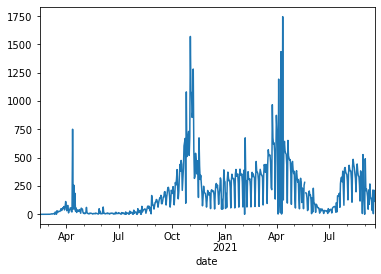

In [261]:
# Inspect each country's data - Is there any negative case values?
country_code = 'FR'
dict_country[country_code]['case_mil'].plot()

In [ ]:
# The negative case values do not make sense, so use forward filling
count_row = 0

if dict_country[country_code]['case_mil'][0]<0:
    dict_country[country_code]['case_mil'][0]=0.0

for row in dict_country[country_code].iterrows():
    if count_row==0:
        if row[1].case_mil<0:
            dict_country[country_code]['case_mil'][count_row]=0.0
    else:
        if row[1].case_mil<0:
         dict_country[country_code]['case_mil'][count_row]=dict_country[country_code]['case_mil'][count_row-1]
    count_row += 1

dict_country[country_code]['case_mil'].plot()

In [240]:
# If necessary, drop the country's data from the dictionary
# dict_country.pop(country_code, None)

In [26]:
for country in dict_country.keys():
    dict_country[country].fillna(method='ffill',inplace=True)